In [1]:
import pandas as pd
from google.colab import drive
import os

In [2]:
from google.colab import files
uploaded = files.upload()

Saving hotel_processing_new.csv to hotel_processing_new (2).csv


In [3]:
hotel=pd.read_csv('hotel_processing_new.csv')

In [4]:
hotel.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,negative_regex,positive_regex
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/17,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3,52.360576,4.915968,room dirty afraid walk barefoot floor look not...,great location nice surroundings bar restauran...
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/17/17,7.7,Hotel Arena,United Kingdom,Cleaner did not change our sheet and duvet ev...,33,1403,The room is spacious and bright The hotel is ...,18,6,4.6,"[' Leisure trip ', ' Group ', ' Duplex Twin Ro...",17,52.360576,4.915968,cleaner not change sheet duvet everyday bed di...,room spacious bright locate quiet beautiful park
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/17/17,7.7,Hotel Arena,United Kingdom,Apart from the price for the brekfast Everyth...,11,1403,Good location Set in a lovely park friendly s...,19,1,10.0,"[' Leisure trip ', ' Couple ', ' Duplex Double...",17,52.360576,4.915968,apart price breakfast good,good location set lovely park friendly staff f...
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/7/17,7.7,Hotel Arena,United Kingdom,Nothing all great,5,1403,Rooms were stunningly decorated and really sp...,101,2,10.0,"[' Leisure trip ', ' Group ', ' Duplex Double ...",27,52.360576,4.915968,great,room stunningly decorate spacious building pic...
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/6/17,7.7,Hotel Arena,United Kingdom,The floor in my room was filfy dirty Very bas...,28,1403,Comfy bed good location,6,7,4.6,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",28,52.360576,4.915968,floor room filthy dirty basic room _NUMBER_ ol...,comfortableee bed good location


In [5]:
hotel.shape

(124881, 19)

In [6]:
hotel['review'] = hotel.positive_regex + hotel.negative_regex

In [7]:
hotel["review_type"] =hotel["Average_Score"].apply(
    lambda x: "poor" if x < 7 else "good")

In [8]:
df_hotel = hotel[["review", "review_type"]]

In [9]:
df_hotel.head()

,review,review_type
0,great location nice surroundings bar restauran...,good
1,room spacious bright locate quiet beautiful pa...,good
2,good location set lovely park friendly staff f...,good
3,room stunningly decorate spacious building pic...,good
4,comfortableee bed good location floor room fil...,good


In [10]:
df_hotel['Good']=[1 if x=='good' else 0 for x in df_hotel['review_type']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
from sklearn.model_selection import train_test_split
train_reviews, test_reviews, y_train, y_test = train_test_split(
    df_hotel.review, 
    df_hotel.Good, 
    test_size=0.2, 
    random_state=42
  )

In [12]:
%%time
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=3,  max_features=None, 
            token_pattern=r'\w{1,}',
            ngram_range=(3, 3),
            stop_words = 'english')

X_train_tfidf =  tfidf.fit_transform(train_reviews.apply(lambda x: np.str_(x))) 
X_test_tfidf = tfidf.transform(test_reviews.apply(lambda x: np.str_(x)))

CPU times: user 3.47 s, sys: 167 ms, total: 3.64 s
Wall time: 3.65 s


In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [14]:
y_pred_test = rf.predict(X_test_tfidf)

In [15]:
# View accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_test)

0.9848260399567602

In [16]:
terms = tfidf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


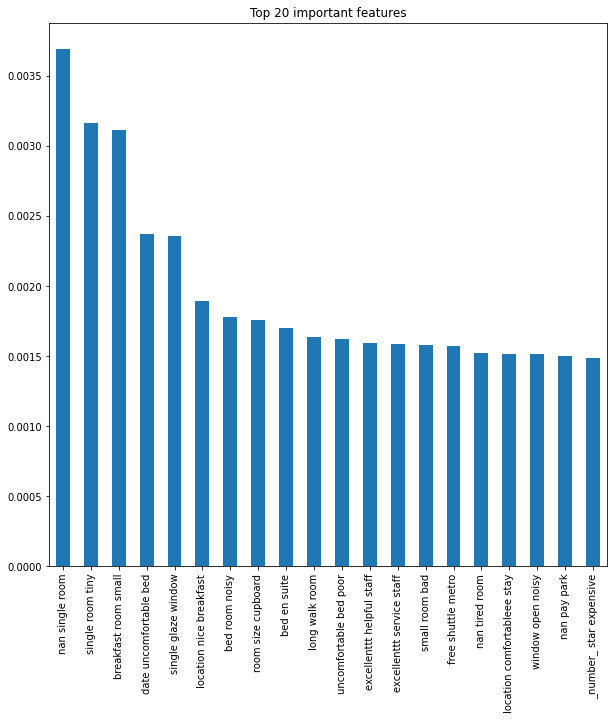

In [17]:
import matplotlib.pyplot as plt
feat_importances = pd.Series(rf.feature_importances_,index=terms)
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10))
plt.title("Top 20 important features")
plt.show()